# Step 2b: Transforming and Splitting

## Import required libraries and variables

In [37]:
import random
import pickle
import numpy as np
import pandas as pd
from joblib import dump
from traffic.core import Traffic, Flight
from multiprocessing import Pool

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [38]:
version = 'v4'

df = pd.read_parquet(
    f"/store/fusg/VT1/training/{version}/traffic_enroute_filtered.parquet"
)
df = df.loc[:, ~df.columns.str.startswith("__index_level_")]
t_enroute = Traffic(df)
print(f"Total en-route segments: {len(t_enroute)}")

frequent_types = np.load(f"/store/fusg/VT1/training/{version}/frequent_typecodes.npy", allow_pickle=True).tolist()
print("Loaded frequent typecodes:", frequent_types)

Total en-route segments: 180514
Loaded frequent typecodes: ['A320', 'B738', 'A319', 'A20N', 'A321', 'B38M', 'BCS3', 'A21N', 'B77W', 'E190', 'B789', 'A333', 'E195', 'A359', 'PC12', 'BCS1']


## Encoding typecode and time

In [39]:
t_encode = t_enroute
t_encode.data = t_enroute.data[t_encode.data['typecode'].isin(frequent_types)]

# Show the difference between total flights and flights with data
print(f"Total flights in t_encode object: {len(t_encode)}")
print(f"Flights that actually have data rows: {t_encode.data['flight_id'].nunique()}")
print(f"Difference (flights with no data): {len(t_encode) - t_encode.data['flight_id'].nunique()}")

# Rebuild t_encode to match reality
t_encode = Traffic(t_encode.data)
print(f"\nAfter rebuilding t_encode:")
print(f"Total flights in t_encode object: {len(t_encode)}")
print(f"Flights that actually have data rows: {t_encode.data['flight_id'].nunique()}")

Total flights in t_encode object: 180514
Flights that actually have data rows: 141659
Difference (flights with no data): 38855

After rebuilding t_encode:
Total flights in t_encode object: 141659
Flights that actually have data rows: 141659


In [40]:
# Definition of columns to be encoded
categorical_variables = ["typecode"]
enc = OneHotEncoder()
enc.fit(t_encode.data[categorical_variables])

# Encoding of the columns and adding them to the DataFrame
encoded_variables = enc.transform(t_encode.data[categorical_variables]).toarray()
new_column_names = enc.get_feature_names_out(categorical_variables)
encoded_df = pd.DataFrame(
    encoded_variables, columns=new_column_names, index=t_encode.data.index
)
t_encode.data = pd.concat([t_encode.data, encoded_df], axis=1)

print(f"Total flights kept: {len(t_encode)}")
t_encode.data.columns

Total flights kept: 141659


Index(['timestamp', 'icao24', 'flight_id', 'callsign', 'typecode', 'latitude',
       'longitude', 'track', 'altitude', 'groundspeed', 'vertical_rate',
       'typecode_A20N', 'typecode_A21N', 'typecode_A319', 'typecode_A320',
       'typecode_A321', 'typecode_A333', 'typecode_A359', 'typecode_B38M',
       'typecode_B738', 'typecode_B77W', 'typecode_B789', 'typecode_BCS1',
       'typecode_BCS3', 'typecode_E190', 'typecode_E195', 'typecode_PC12'],
      dtype='object')

In [41]:
t_encode.data['timestamp'] = pd.to_datetime(t_encode.data['timestamp'])

# Extract hour, weekday and month
t_encode.data['hour'] = t_encode.data['timestamp'].dt.hour
t_encode.data['weekday'] = t_encode.data['timestamp'].dt.weekday
t_encode.data['month'] = t_encode.data['timestamp'].dt.month

def add_cyclic(df, col, period):
    angle = 2 * np.pi * df[col] / period
    df[f"{col}_sin"] = np.sin(angle)          # range [-1, 1]
    df[f"{col}_cos"] = np.cos(angle)
    return df

t_encode.data = add_cyclic(t_encode.data, "hour",    24)
t_encode.data = add_cyclic(t_encode.data, "weekday",  7)
t_encode.data = add_cyclic(t_encode.data, "month",   12)

print(f"Total flights kept: {len(t_encode)}")
t_encode.data.columns

Total flights kept: 141659


Index(['timestamp', 'icao24', 'flight_id', 'callsign', 'typecode', 'latitude',
       'longitude', 'track', 'altitude', 'groundspeed', 'vertical_rate',
       'typecode_A20N', 'typecode_A21N', 'typecode_A319', 'typecode_A320',
       'typecode_A321', 'typecode_A333', 'typecode_A359', 'typecode_B38M',
       'typecode_B738', 'typecode_B77W', 'typecode_B789', 'typecode_BCS1',
       'typecode_BCS3', 'typecode_E190', 'typecode_E195', 'typecode_PC12',
       'hour', 'weekday', 'month', 'hour_sin', 'hour_cos', 'weekday_sin',
       'weekday_cos', 'month_sin', 'month_cos'],
      dtype='object')

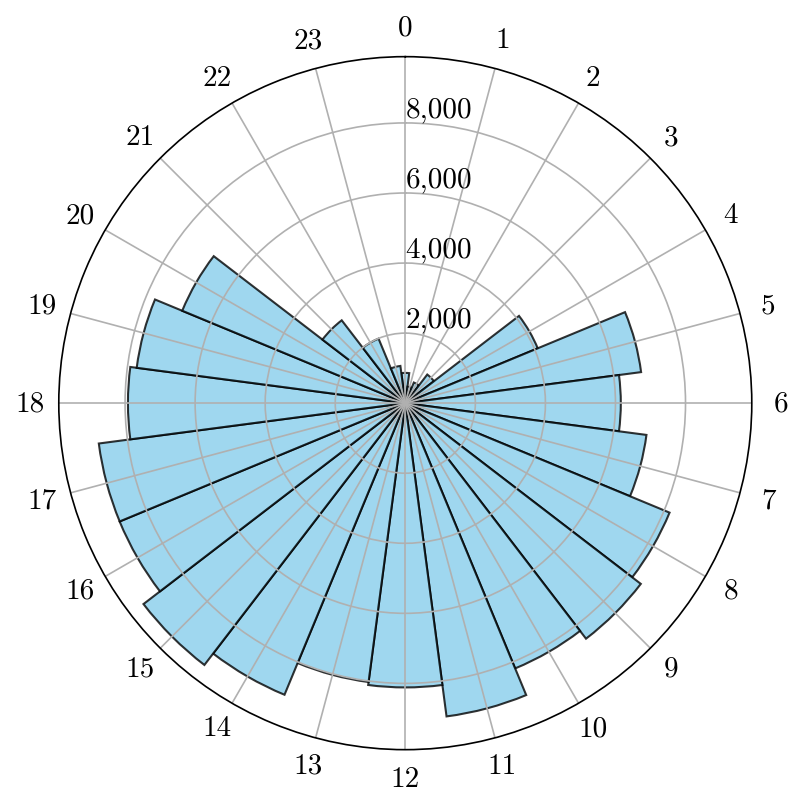

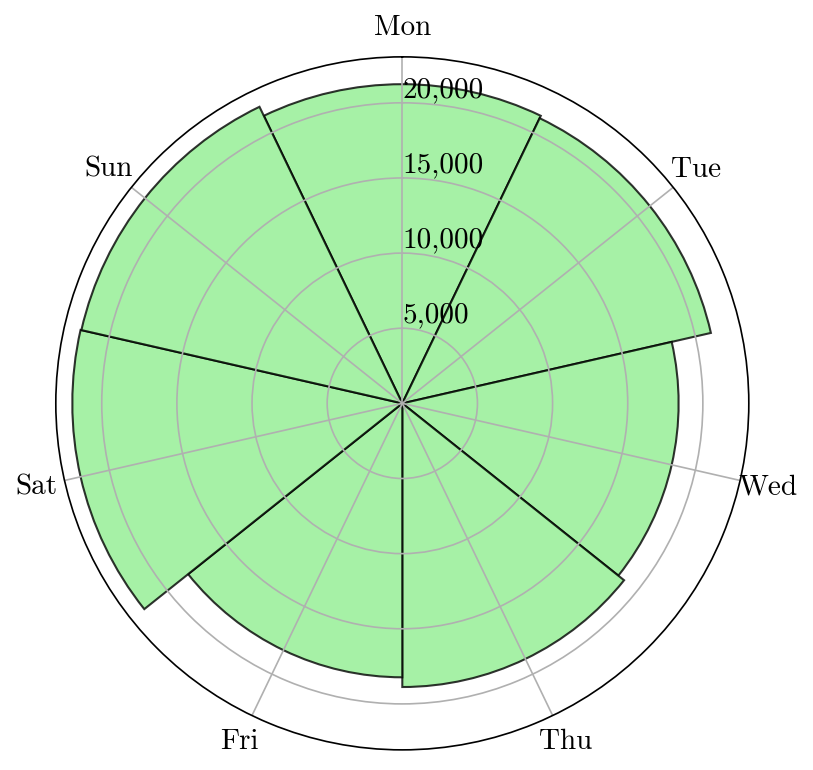

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

plt.rcParams.update({
    'text.usetex': False,
    'axes.formatter.use_mathtext' : True,
    'font.family': 'cmr10',
    'font.size': 15,
    'axes.labelsize': 17,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.dpi': 150
})

# Per-flight cyclic presentation: use the first timestamp of each flight
firsts = t_encode.data.sort_values('timestamp').groupby('flight_id').first()

# Hour per flight
hour_counts = firsts['hour'].value_counts().sort_index()
hours = np.arange(24)
counts = hour_counts.reindex(hours, fill_value=0).values
angles = 2 * np.pi * hours / 24

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
ax.bar(angles, counts, width=2*np.pi/24, bottom=0.0, color='skyblue', edgecolor='k', alpha=0.8)
ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
ax.set_xticklabels([str(h) for h in hours])
#ax.set_title('Cyclic Distribution of Flights by Hour (first timestamp)', va='bottom')

ax.set_rlabel_position(0)  # (optional) sets the position of the radial labels
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.show()

# Weekday per flight
weekday_counts = firsts['weekday'].value_counts().sort_index()
weekdays = np.arange(7)
counts_wd = weekday_counts.reindex(weekdays, fill_value=0).values
angles_wd = 2 * np.pi * weekdays / 7

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
ax.bar(angles_wd, counts_wd, width=2*np.pi/7, bottom=0.0, color='lightgreen', edgecolor='k', alpha=0.8)
ax.set_xticks(np.linspace(0, 2*np.pi, 7, endpoint=False))
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
#ax.set_title('Cyclic Distribution of Flights by Weekday (first timestamp)', va='bottom')

ax.set_rlabel_position(0)  # (optional) sets the position of the radial labels
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.show()


## Scaling numerical features

In [25]:
def add_numerical_features(df):
    df = df.copy()

    df["timestamp"] = df["timestamp"].dt.tz_localize(None)
    secs = df["timestamp"].diff().dt.total_seconds().fillna(1.0)

    # protect against 0-second gaps
    secs[secs == 0] = 1.0

    # --- sin/cos of track ----------------------------------------
    tr_rad = np.deg2rad(df["track"])
    df["track_sin"] = np.sin(tr_rad)
    df["track_cos"] = np.cos(tr_rad)

    # --- heading‐rate  (deg/s) ------------------------------------
    tr_unw  = np.unwrap(tr_rad)
    hdg_rate = np.diff(np.insert(tr_unw, 0, tr_unw[0])) / secs
    df["heading_rate"] = hdg_rate * 180 / np.pi

    # --- groundspeed change  (m/s²) -------------------------------
    df["groundspeed_change"] = (
        df["groundspeed"].diff().fillna(0) / secs
    )

    # --- vertical acceleration  (m/s²) ---------------------------
    df["vert_acc"] = df["vertical_rate"].diff().fillna(0) / (secs)

    return df

t_encode.data = add_numerical_features(t_encode.data)
print(f"Total flights kept: {len(t_encode)}")
print(t_encode.data.columns)

Total flights kept: 141659
Index(['timestamp', 'icao24', 'flight_id', 'callsign', 'typecode', 'latitude',
       'longitude', 'track', 'altitude', 'groundspeed', 'vertical_rate',
       'typecode_A20N', 'typecode_A21N', 'typecode_A319', 'typecode_A320',
       'typecode_A321', 'typecode_A333', 'typecode_A359', 'typecode_B38M',
       'typecode_B738', 'typecode_B77W', 'typecode_B789', 'typecode_BCS1',
       'typecode_BCS3', 'typecode_E190', 'typecode_E195', 'typecode_PC12',
       'hour', 'weekday', 'month', 'hour_sin', 'hour_cos', 'weekday_sin',
       'weekday_cos', 'month_sin', 'month_cos', 'track_sin', 'track_cos',
       'heading_rate', 'groundspeed_change', 'vert_acc', 'date', 'day_bucket',
       'typecode_A20N', 'typecode_A21N', 'typecode_A319', 'typecode_A320',
       'typecode_A321', 'typecode_A333', 'typecode_A359', 'typecode_B38M',
       'typecode_B738', 'typecode_B77W', 'typecode_B789', 'typecode_BCS1',
       'typecode_BCS3', 'typecode_E190', 'typecode_E195', 'typecode_P

In [26]:
# Verify no inf / -inf
bad_vals = np.isinf(t_encode.data[["groundspeed_change","vert_acc","heading_rate"]]).any()
print("Any infinite values?", bad_vals)

Any infinite values? groundspeed_change    False
vert_acc              False
heading_rate          False
dtype: bool


In [27]:
df = t_encode.data
df["date"] = df["timestamp"].dt.date

unique_days = df["date"].unique().tolist()
random.shuffle(unique_days)

n_days       = len(unique_days)
days_train   = set(unique_days[: int(0.6 * n_days)])
days_val     = set(unique_days[int(0.6 * n_days): int(0.8 * n_days)])
days_test    = set(unique_days[int(0.8 * n_days):])

def bucket_day(day):
    if day in days_train: return "train"
    if day in days_val:   return "val"
    return "test"

df["day_bucket"] = df["date"].map(bucket_day)

# keep all flight segments of a flight_id inside its day bucket
train_mask = (df["day_bucket"] == "train")
val_mask   = (df["day_bucket"] == "val")
test_mask  = (df["day_bucket"] == "test")

# sanity checks
print("Rows train :", train_mask.sum())
print("Rows val   :", val_mask.sum())
print("Rows test  :", test_mask.sum())

print("Unique flight_id in train :", df.loc[train_mask, "flight_id"].nunique())
print("Unique flight_id in val   :", df.loc[val_mask,   "flight_id"].nunique())
print("Unique flight_id in test  :", df.loc[test_mask,  "flight_id"].nunique())

Rows train : 58328254
Rows val   : 20296308
Rows test  : 20054010
Unique flight_id in train : 81996
Unique flight_id in train : 81996
Unique flight_id in val   : 29587
Unique flight_id in val   : 29587
Unique flight_id in test  : 30076
Unique flight_id in test  : 30076


In [28]:
all_flights = set(t_encode.flight_ids)
split_flights = set(df["flight_id"].unique())
print("Flights in t_encode but not in splits:", len(all_flights - split_flights))
print("Flights in splits but not in t_encode:", len(split_flights - all_flights))
print("Flights in both:", len(all_flights & split_flights))
print("len(t_encode):", len(t_encode))
print("sum of unique flights in splits:", 
      df.loc[train_mask, "flight_id"].nunique() + 
      df.loc[val_mask, "flight_id"].nunique() + 
      df.loc[test_mask, "flight_id"].nunique())

Flights in t_encode but not in splits: 0
Flights in splits but not in t_encode: 0
Flights in both: 141659
len(t_encode): 141659
sum of unique flights in splits: 141659
sum of unique flights in splits: 141659


In [ ]:
base       = "/store/fusg/VT1/training"
vars_dir   = f"{base}/{version}/variables"

num_in_cols = [
    "latitude", "longitude", "altitude",
    "vertical_rate", "groundspeed",
    "heading_rate", "groundspeed_change", "vert_acc"
]
out_cols = num_in_cols #["latitude", "longitude", "altitude"]

scaler_in  = MinMaxScaler().fit(df.loc[train_mask, num_in_cols])
scaler_out = MinMaxScaler().fit(df.loc[train_mask, out_cols])

with open(f"{vars_dir}/scaler_in.pkl",  "wb") as f:
    pickle.dump(scaler_in, f)
with open(f"{vars_dir}/scaler_out.pkl", "wb") as f:
    pickle.dump(scaler_out, f)

for col in num_in_cols:
    df[f"{col}_scaled"] = scaler_in.transform(df[num_in_cols])[:, num_in_cols.index(col)]
for col in out_cols:
    df[f"{col}_scaled"] = scaler_out.transform(df[out_cols])[:, out_cols.index(col)]

print("Scaled INPUT sample:")
print(df[[f"{c}_scaled" for c in num_in_cols]].head())
print("\nScaled OUTPUT sample:")
print(df[[f"{c}_scaled" for c in out_cols]].head())

Scaled INPUT sample:
   latitude_scaled  longitude_scaled  altitude_scaled  vertical_rate_scaled  \
0         0.107697          0.341189         0.333333              0.500000   
1         0.107697          0.341189         0.333333              0.500000   
2         0.108013          0.341169         0.333333              0.500721   
3         0.108285          0.341156         0.333333              0.501074   
4         0.108570          0.341136         0.333333              0.501718   

   groundspeed_scaled  heading_rate_scaled  groundspeed_change_scaled  \
0            0.061093             0.499927                   0.504169   
1            0.061093             0.499927                   0.504169   
2            0.061099             0.499813                   0.504174   
3            0.061107             0.499489                   0.504176   
4            0.061107             0.499927                   0.504169   

   vert_acc_scaled  
0         0.494521  
1         0.494521  
2 

## Spliting the data into Training, Testing and Validation

In [10]:
ids_train = df.loc[train_mask, "flight_id"].unique().tolist()
ids_val   = df.loc[val_mask,   "flight_id"].unique().tolist()
ids_test  = df.loc[test_mask,  "flight_id"].unique().tolist()

t_train = t_encode[ids_train]
t_val   = t_encode[ids_val]
t_test  = t_encode[ids_test]

print(f"Train flights: {len(t_train)}")
print(f"Val flights:   {len(t_val)}")
print(f"Test flights:  {len(t_test)}")

Train flights: 83269
Val flights:   29123
Test flights:  29267


In [11]:
# Save the data
t_train.reset_index(drop=True).to_parquet(
    f"/store/fusg/VT1/training/{version}/variables/t_train.parquet"
)
t_val.reset_index(drop=True).to_parquet(
    f"/store/fusg/VT1/training/{version}/variables/t_val.parquet"
)
t_test.reset_index(drop=True).to_parquet(
    f"/store/fusg/VT1/training/{version}/variables/t_test.parquet"
)

In [12]:
t_train.data.columns

Index(['timestamp', 'icao24', 'flight_id', 'callsign', 'typecode', 'latitude',
       'longitude', 'track', 'altitude', 'groundspeed', 'vertical_rate',
       'typecode_A20N', 'typecode_A21N', 'typecode_A319', 'typecode_A320',
       'typecode_A321', 'typecode_A333', 'typecode_A359', 'typecode_B38M',
       'typecode_B738', 'typecode_B77W', 'typecode_B789', 'typecode_BCS1',
       'typecode_BCS3', 'typecode_E190', 'typecode_E195', 'typecode_PC12',
       'hour', 'weekday', 'month', 'hour_sin', 'hour_cos', 'weekday_sin',
       'weekday_cos', 'month_sin', 'month_cos', 'track_sin', 'track_cos',
       'heading_rate', 'groundspeed_change', 'vert_acc', 'date', 'day_bucket',
       'latitude_scaled', 'longitude_scaled', 'altitude_scaled',
       'vertical_rate_scaled', 'groundspeed_scaled', 'heading_rate_scaled',
       'groundspeed_change_scaled', 'vert_acc_scaled'],
      dtype='object')